In [1]:
import logging
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import elfi
from sim.utils import ScaledDist, plot_dist
from sim.model import elfi_sim
from sim.sum_stats import elfi_summary
import scipy.stats
from sklearn.preprocessing import StandardScaler

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)


### Priors

To ensure proper scaling the parameters (exluding migration rates) are given as ScaledDists, for which the sampling distributions are on similar scales, and they are then scaled up in the simulator.

In [2]:
scaled_priors = {
    "bottleneck_strength_domestic": ScaledDist(scipy.stats.uniform(loc=0, scale=1),
                                               scipy.stats.uniform(loc=0, scale=30000)),
    "bottleneck_strength_wild": ScaledDist(scipy.stats.uniform(loc=0, scale=1),
                                           scipy.stats.uniform(loc=0, scale=30000)),
    "bottleneck_time_domestic": ScaledDist(scipy.stats.norm(loc=0, scale=1),
                                           scipy.stats.norm(loc=3500, scale=300)),
    "bottleneck_time_wild": ScaledDist(scipy.stats.norm(loc=0, scale=1),
                                       scipy.stats.norm(loc=3500, scale=300)),
    "captive_time": ScaledDist(scipy.stats.lognorm(s=0.7, loc=0, scale=1),
                               scipy.stats.lognorm(s=0.7, loc=1, scale=np.exp(3))),
    "div_time": ScaledDist(scipy.stats.norm(loc=0, scale=1),
                           scipy.stats.norm(loc=30000, scale=1000)),
    "mig_length_post_split": ScaledDist(scipy.stats.uniform(loc=0, scale=1),
                                        scipy.stats.uniform(loc=0, scale=10000)),
    "mig_length_wild": ScaledDist(scipy.stats.lognorm(s=0.7, loc=0, scale=1),
                                  scipy.stats.lognorm(s=0.7, loc=1, scale=np.exp(3))),
    "pop_size_wild_1": ScaledDist(scipy.stats.truncnorm(a=-2, b=np.inf, loc=0, scale=1),
                                  scipy.stats.truncnorm(a=-2, b=np.inf, loc=100, scale=35)),
    "pop_size_wild_2": ScaledDist(scipy.stats.truncnorm(a=-2, b=np.inf, loc=0, scale=1),
                                  scipy.stats.truncnorm(a=-2, b=np.inf, loc=100, scale=35)),
    "pop_size_captive": ScaledDist(scipy.stats.truncnorm(a=-2, b=np.inf, loc=0, scale=1),
                                   scipy.stats.truncnorm(a=-2, b=np.inf, loc=100, scale=35)),
    "pop_size_domestic_1": ScaledDist(scipy.stats.truncnorm(a=-2, b=np.inf, loc=0, scale=1),
                                      scipy.stats.truncnorm(a=-2, b=np.inf, loc=100, scale=35)),
    "pop_size_domestic_2": ScaledDist(scipy.stats.truncnorm(a=-2, b=np.inf, loc=0, scale=1),
                                      scipy.stats.truncnorm(a=-2, b=np.inf, loc=100, scale=35)),
}

mig_rate_priors = {
    "mig_rate_captive": scipy.stats.beta(1.2, 10),
    "mig_rate_post_split": scipy.stats.beta(1.2, 10),
    "mig_rate_wild": scipy.stats.beta(1.2, 10),
}

priors = {**scaled_priors, **mig_rate_priors}


### Add priors to model and plot

In [3]:
m = elfi.ElfiModel("m")

elfi.Constant(int(5e6), name="length", model=m)
elfi.Constant(1.8e-8, name="recombination_rate", model=m)
elfi.Constant(6e-8, name="mutation_rate", model=m)

for prior_name, prior in priors.items():
    
    if isinstance(prior, ScaledDist):
        elfi.Prior(prior.sampling, name=prior_name, model=m)
        prior.plot(x_lab=prior_name)
    else:
        elfi.Prior(prior, name=prior_name, model=m)
        plot_dist(prior, prior_name)    
    plt.savefig("../plots/prior/{}.png".format(prior_name))
    plt.clf()


<Figure size 432x288 with 0 Axes>

### POD

In [4]:
y_obs = elfi_sim(length=int(5e6),
            recombination_rate=1.8e-8,
            mutation_rate=6e-8,
            pop_size_domestic_1=[100],
            pop_size_wild_1=[100],
            pop_size_captive=[100],
            captive_time=[20],
            mig_rate_captive=[0.01],
            mig_length_wild=[20],
            mig_rate_wild=[0.01],
            pop_size_domestic_2=[100],
            pop_size_wild_2=[100],
            div_time=[20000],
            mig_rate_post_split=[0.1],
            mig_length_post_split=[1000],
            bottleneck_time_wild=[3000],
            bottleneck_strength_wild=[10000],
            bottleneck_time_domestic=[3000],
            bottleneck_strength_domestic=[3000],
            random_state=np.random.RandomState(3),
            batch_size=1) 

In [5]:
prior_args = [m[name] for name in m.parameter_names]  # Model only contains priors and constants

y = elfi.Simulator(elfi_sim, *prior_args, m["length"], m["recombination_rate"],
                   m["mutation_rate"], scaled_priors, name="simulator", observed=y_obs)

s = elfi.Summary(elfi_summary, y, None, True, name='s', model=m)  # None = no scaler, True = quick_mode

d = elfi.Distance('euclidean', s, name='d', model=m)

### Carry out simulations to "train" sum stat scaler

In [6]:
seed = 1
pool = elfi.OutputPool(['s'])
rej = elfi.Rejection(m['d'], batch_size=4, seed=1, pool=pool)
rej_res = rej.sample(50, quantile=1)  # Accept all
store = pool.get_store('s')
sum_stats = np.array(list(store.values()))
sum_stats = sum_stats.reshape(-1, sum_stats.shape[2])  # Drop batches axis
scaler = StandardScaler()
scaler.fit(sum_stats)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


StandardScaler()

In [7]:
m["s"].become(elfi.Summary(elfi_summary, y, scaler, True, name='s_scaled', model=m))  # Scaler and quick_mode

### SMC

In [8]:
%%time
smc = elfi.SMC(m['d'], batch_size=5, seed=1)
N = 100
schedule = [12, 11, 10]
result_smc = smc.sample(N, schedule)
result_smc.summary(all=True)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: SMC
Number of samples: 100
Number of simulations: 535
Threshold: 10
Sample means: bottleneck_strength_domestic: 0.58, bottleneck_strength_wild: 0.473, bottleneck_time_domestic: 0.159, bottleneck_time_wild: -0.534, captive_time: 1.37, div_time: -0.141, mig_length_post_split: 0.809, mig_length_wild: 1.34, mig_rate_captive: 0.102, mig_rate_post_split: 0.106, mig_rate_wild: 0.0753, pop_size_captive: 0.423, pop_size_domestic_1: -0.0723, pop_size_domestic_2: -0.38, pop_size_wild_1: -0.362, pop_size_wild_2: 0.14

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 100
Number of simulations: 115
Threshold: 11.9
Sample means: bottleneck_strength_domestic: 0.473, bottleneck_strength_wild: 0.508, bottleneck_time_domestic: 0.17, bottleneck_time_wild: 0.0377, captive_time: 1.35, div_time: 0.103, mig_length_post_split: 0.538, mig_length_wild: 1.25, mig_rate_captive: 0.1, mig_rate_post_split: 0.102, m

In [9]:
samples = result_smc.samples_array
weights = result_smc.weights

In [105]:
import pandas as pd
results = pd.DataFrame(samples, columns=sorted(priors.keys()))
results["weights"] = result_smc.weights

In [ ]:
# scale back up results

In [112]:
scaled_priors["div_time"].scale_up_samples

In [113]:
for name, dist in scaled_priors.items():
    results[name] = dist.scale_up_samples(results[name])

In [116]:
results.to_csv("../output/smc_posterior.csv", index=False)

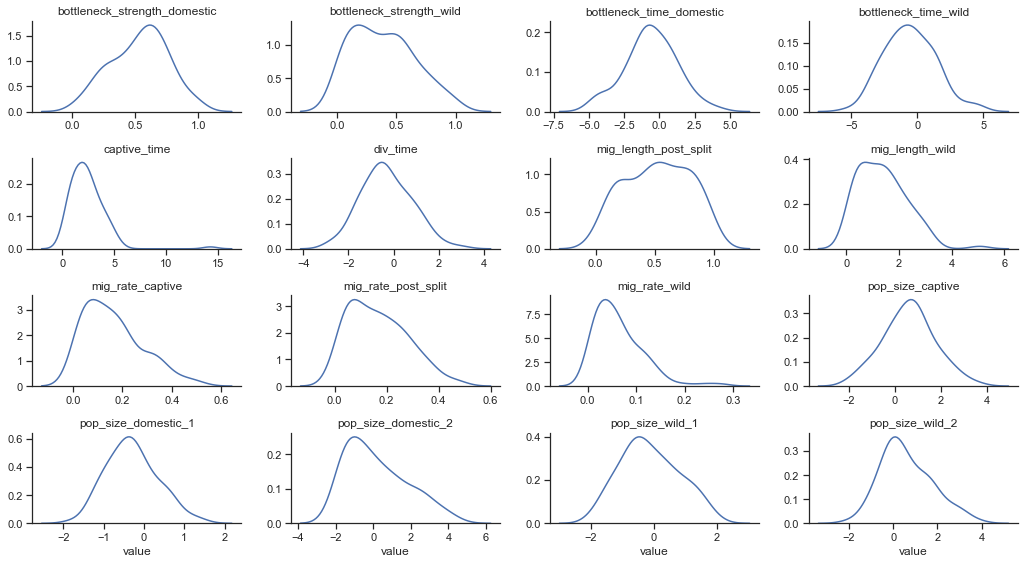

In [100]:
melt_results = results.melt(var_name="parameter")
g = sns.FacetGrid(melt_results, col="parameter", col_wrap=4, height=2, aspect=1.8, sharex=False, sharey=False)
g = (g.map(sns.kdeplot, "value"))
g.set_titles("{col_name}")


In [127]:
df_list = []

for name, dist in priors.items():
    if isinstance(dist, ScaledDist):
        dist = dist.target
    x_lims = dist.ppf([0.001, 0.999])
    x = np.linspace(x_lims[0], x_lims[1], 1000)
    y = dist.pdf(x)
    df = pd.DataFrame({"x": x, "parameter": name, "value": y})
    df_list.append(df)
    
    

In [131]:
pdf_df = pd.concat(df_list)

In [134]:
pdf_df.to_csv("../output/prior_pdf.csv", index=False)

In [102]:
melt_priors = prior_pdfs.melt(id_vars=["x"], var_name="parameter")

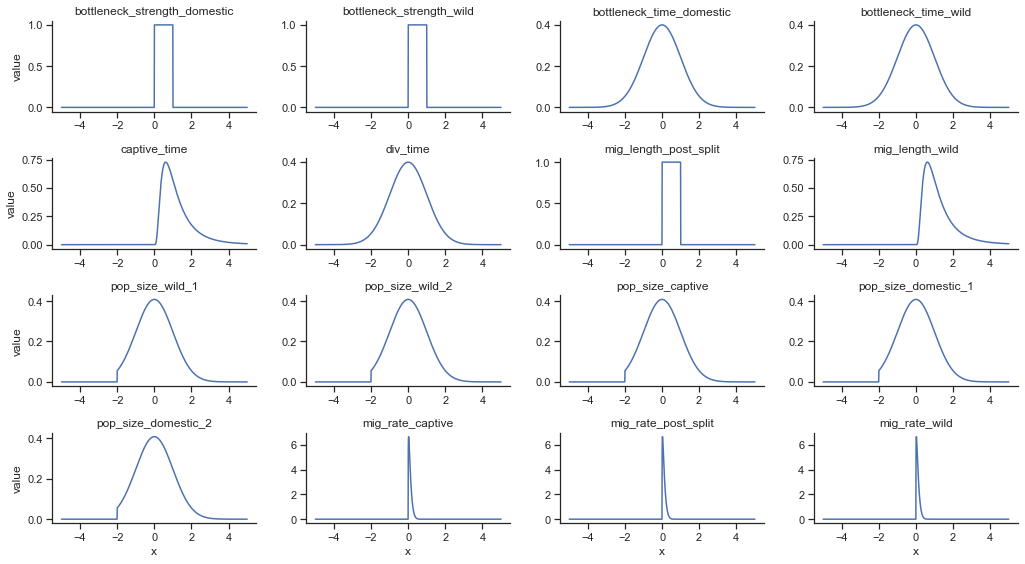

In [103]:
g = sns.FacetGrid(melt_priors, col="parameter", col_wrap=4, height=2, aspect=1.8, sharex=False, sharey=False)
g = (g.map(sns.lineplot, "x", "value"))
g.set_titles("{col_name}")

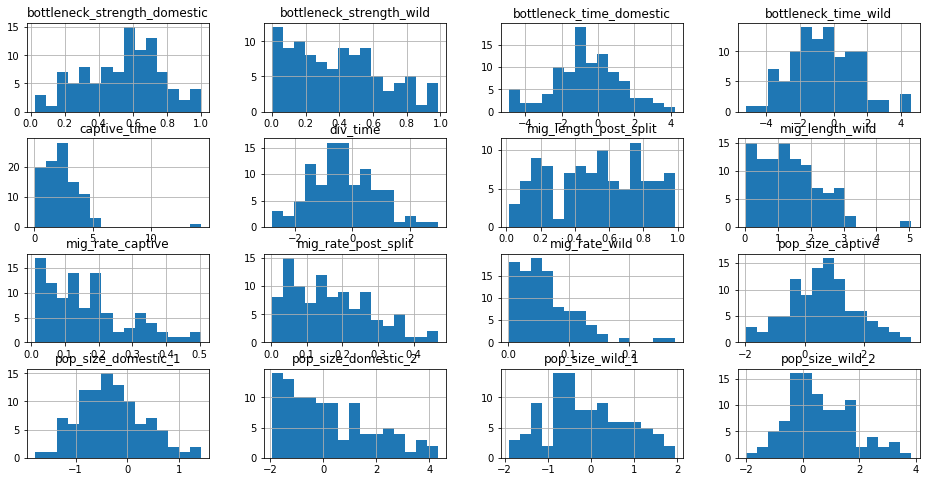

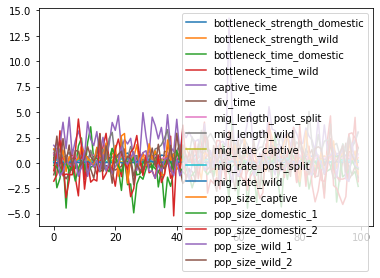

In [13]:
fig, axis = plt.subplots(4,4, figsize=(16, 8))
results.hist(ax=axis, bins=15)
results.plot()